# 사이즈가 중요하다



### 시가총액 기준 분위수 분석
* 어떤 한 시점에 상장된 주식들의 지난 몇년간의 시가총액 평균을 전부 크기에 따라 줄 세울수 있습니다 ✨
* 다섯 구간으로 나누어 생각해볼까요? 예를 들어 상위 20%, 그 및 20% ... 최하위 20% 이렇게요.

In [1]:
from core.constants import TableKey
from core.strategy import Selector, SelectorType, SelectorSequence, Filter

target_key = TableKey.FinancialRatios.Quarter.PER
n_division = 4
lookback_year = 1

filter_list = []
relative_range_list = [(i / n_division, (i + 1) / n_division) for i in range(n_division)]
relative_range_list.append((0.0, 1.0))

for relative_value_range in relative_range_list:
    filter_name = target_key + '=(' + str(relative_value_range[0]) + '-' + str(relative_value_range[1]) + ')'
    relative_selector = Selector(type=SelectorType.HORIZON_RANGE, key=target_key, value=relative_value_range,
                                 horizon=lookback_year,
                                 is_absolute=False)
    selector_sequence = SelectorSequence(selectors=[relative_selector])
    filter_list.append(Filter(selector_sequence_union=[selector_sequence], name=filter_name))

### 시뮬레이션 준비
* 자! 그럼 이제 **주어진 기간동안** (e.g., 1960년 ~ 2022년) 까지 일정한 주기로 (e.g., 3개월마다) 주식들을 골라서 갖고 있어보아요
* 고를때 A 라는 사람은 시가총액 상위 20% 만 B 라는 전략가는 상위 20%-40% 만 .. E 라는 사람은 하위 20 % 만 꾸준히 산다고 가정해볼게요.
* 일단 전체 모집단은 [NYSE, NASDAQ, ...? ] 의 주식으로 해볼게요!

In [5]:
from datetime import date
from core.db_interface import DataBaseInterface
from core.strategy import Strategist
import pandas as pd
from tqdm import tqdm

db_interface = DataBaseInterface()

exchange_pool = ['NYSE', 'NASDAQ']
horizon = (date(2010, 1, 1), date(2022, 8, 22))
freq = '6M'

initial_symbols = db_interface.get_stock_on_exchange(exchange_pool)
rebalance_dates = pd.date_range(horizon[0], horizon[1], freq=freq, inclusive='both')
strategist_list = []


tqdm_object = tqdm(total=len(filter_list) * len(rebalance_dates))
tqdm_object.set_description(f"동양여우가 {len(initial_symbols)}개의 주식 중에서 고르는 중 ")

with tqdm_object as pbar:
    for filter_ in filter_list:
        strategist_name = filter_.name
        strategist = Strategist(fetcher=db_interface, name=strategist_name, asset_pool=initial_symbols,
                                start_date=horizon[0], end_date=horizon[1])
        for rebalance_date in rebalance_dates:
            strategist.apply_filter(filter_in=filter_, date_in=rebalance_date.date())
            pbar.update(1)
        strategist_list.append(strategist)

print("다 되었어요!")

동양여우가 1596개의 주식 중에서 고르는 중 : 100%|██████████| 130/130 [00:18<00:00,  7.12it/s]

다 되었어요!


## 자, 그럼 우리가 여태 고른 주식들은 어떤 종목들이었는지 살펴볼까요? 😍
* 우선 각 전략별로 통 기간동안 고른 주식들의 섹터별 합계를 한번 봐볼게요.
* PER 높은 것에 배팅하는 전략은 인기주를 위주로, 그렇지 않은 전략은 전통주 위주로 했으리라 예상을 할 수 있겠죠?

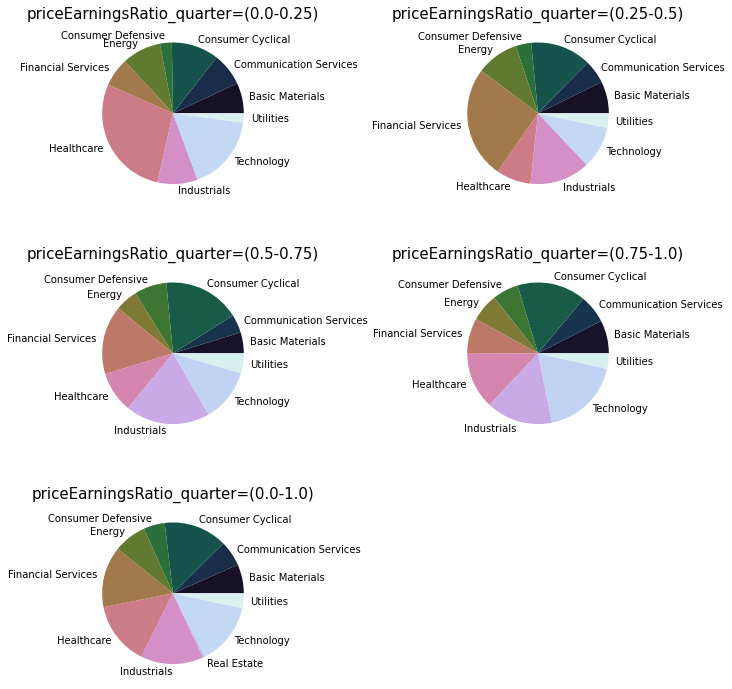

In [3]:
from core.evaluate import show_selection
import matplotlib.pyplot as plt
import math

n_strategist = len(strategist_list)
col = 2
row = math.ceil(n_strategist/2)
plt.rcParams.update({'font.size': 10})
plt.rcParams['figure.dpi'] = 100  # default for me was 75
plt.subplots(constrained_layout=True, figsize=(10, 10))

for idx, strategist in enumerate(strategist_list):
    plt.subplot(row , col, idx+1)
    show_selection(strategist, db_interface,
               {'radius': 1, 'fontsize': 15, 'palette': "cubehelix", 'labeldistacne': 1.1})

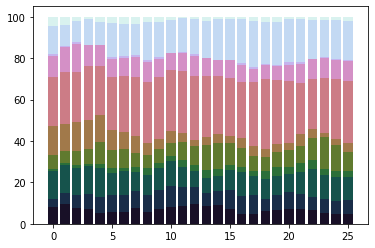

In [4]:
from core.evaluate import extract_sector_count_from_segment, SECTOR_COLOR_MAP

for idx, segment in enumerate(strategist_list[0].state[1:]):
    sector_counts = extract_sector_count_from_segment(segment, db_interface)
    bottom = 0
    for index, sector in sector_counts.items():
        color = SECTOR_COLOR_MAP[index]
        height = sector
        plt.bar(idx, height, bottom=bottom, color=color)
        bottom += height

In [ ]:
"""
1. up / down days,
2. 수익률 분석 기간별로
3. segment 별로 주요 지표들 특징 요약
"""